# AlexNet

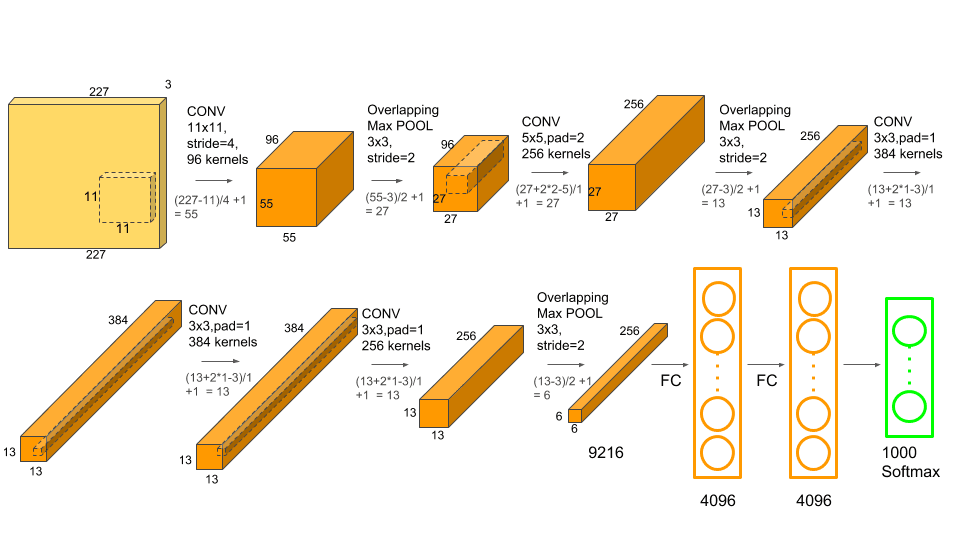


논문에서 본 구조랑 살짝 다르다. 그 이유는 gpu를 하나만 이용하기 때문인 것 같다. 실제로 channel 들이 실제 논문의 이미지의 2배이다.

## ReLU

아마 이 시기에는 tanh를 자주 사용했나보다.

tanh는 (-1,1)이기 때문에, saturating이 발생한다. 하지만 ReLU는 max(0,x) 이기 때문에 발생하지 않는다.

## Local Response Normalization

대신 ReLU를 사용하게 될 경우에는, 어떤 한 pixel이 큰 값을 가질 수 있다.(max(0,x))

그렇기 때문에 conv를 하게 되면, 영향이 적은 pixel들이 많음에도 불구하고 값이 튈 수 있어서 이러한 연산을 적용한다.

alexnet이 나온지 오래 되어서 그런지, 최근 코드에서는 이러한 연산을 못 본 거 같다. 대신 normalize를 사용하는 것 같다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
%matploblib inline

UsageError: Line magic function `%matploblib` not found.


In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=100):
    super(AlexNet, self).__init__()


    # 논문에서 저자들이 layer가 총 8개 있다고 해서, 이렇게 구성하였다.

    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 96, 11, 4), # 96 x 55 x 55
        nn.ReLU(),
        nn.LocalResponseNorm(size = 5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3,2), #96 x 27 x 27
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(96, 256, 5, padding=2), # 256 x 27 x 27
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3, 2), # 256 x 13 x 13,
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(256, 384, 3, padding=1), # 384 x 13 x 13
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
    )
    
    self.layer4 = nn.Sequential(
        nn.Conv2d(384, 384, 3, padding=1), # 384 x 13 x 13
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
    )

    self.layer5 = nn.Sequential(
        nn.Conv2d(384, 256, 3, padding=1), # 256 x 13 x 13
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3,2) # 256 x 6 x 6
    )

    self.layer6 = nn.Sequential(
        nn.Linear(256*6*6, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
    )

    self.layer7 = nn.Sequential(
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
    )

    self.layer8 = nn.Sequential(
        nn.Linear(4096, num_classes),
        #nn.Softmax(dim=-1)
    )

  def forward(self, x):
    outputs = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
    outputs = outputs.view(outputs.size(0), 256*6*6)
    outputs = self.layer8(self.layer7(self.layer6(outputs)))
    return outputs




Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50016


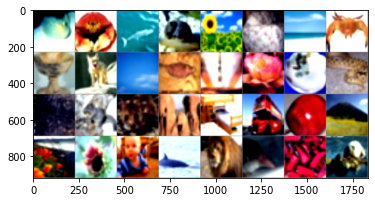

In [ ]:
import torchvision
import torchvision.transforms as transforms

batch_size = 32

train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])


test_transform = transforms.Compose([
                                     transforms.Resize(227),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

# 이미지 보여주기
print(len(train_loader)*32)
imshow(torchvision.utils.make_grid(images))



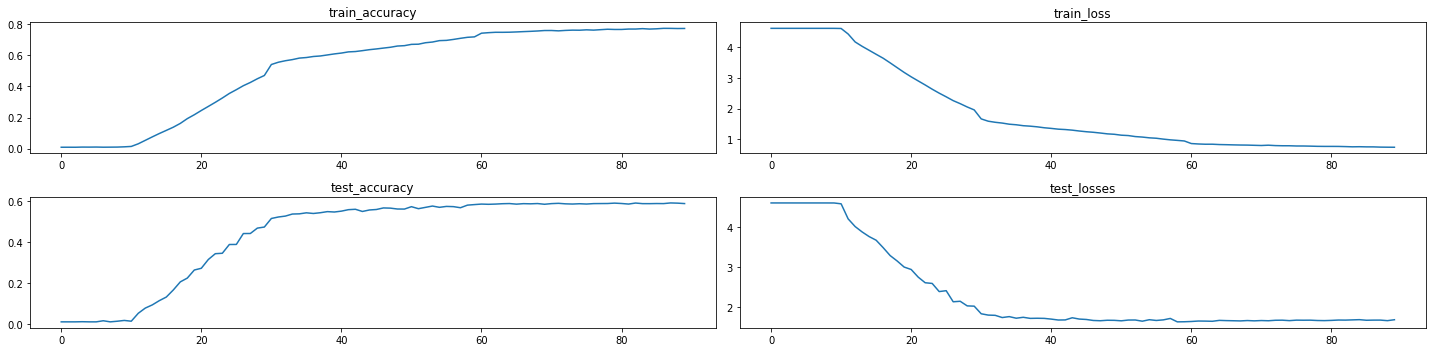

In [ ]:
def plot(epochs, train_losses, train_accs, test_losses, test_accs):
  clear_output()
  plt.figure(figsize = (20,5))
  plt.title('epoch {0}'.format(epochs[-1]))
  plt.subplot(221)
  plt.title('train_accuracy')
  plt.plot(train_accs)
  plt.subplot(222)
  plt.title('train_loss')
  plt.plot(train_losses)
  plt.subplot(223)
  plt.title('test_accuracy')
  plt.plot(test_accs)
  plt.subplot(224)
  plt.title('test_losses')
  plt.plot(test_losses)
  plt.tight_layout()
  plt.show()


def fit(model, epochs, device, optimizer, criterion, lr_scheduler, train_loader, test_loader):
  epoch_range = []
  
  train_losses = []
  test_losses = []

  train_accs = []
  test_accs = []
  i = 1

  model.to(device)
  for epoch in range(epochs):


    train_loss = 0.
    train_acc = 0.

    model.train()
    for data, target in train_loader:
      data = data.to(device)
      target = target.long().to(device)

      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()

      acc = (output.argmax(dim=1) == target).float().mean()
      train_loss += loss
      train_acc += acc

      optimizer.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)


    test_loss, test_acc = 0., 0.

    model.eval()
    for data, target in test_loader:
      data = data.to(device)
      target = target.long().to(device)

      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
        acc = (output.argmax(dim=1)==target).float().mean()
        
        test_loss += loss
        test_acc += acc

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    test_losses.append(test_loss)
    test_accs.append(test_acc)

    epoch_range.append(i)
    i += 1
        
    lr_scheduler.step()
    plot(epoch_range, train_losses, train_accs, test_losses, test_accs)


def run(model):
  NUM_EPOCHS = 90  # original paper
  BATCH_SIZE = 128
  MOMENTUM = 0.9
  LR_DECAY = 0.0005
  LR = 0.01

  train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(227),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
  ])


  test_transform = transforms.Compose([
                                      transforms.Resize(227),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
  ])

  train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

  test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

  optimizer = optim.SGD(params=model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=LR_DECAY)
  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

  criterion = nn.CrossEntropyLoss()

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  fit(model, NUM_EPOCHS, device, optimizer, criterion, lr_scheduler, train_loader, test_loader)

model = AlexNet(100)

run(model)

